# Analyse Order 2 order 1

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : May 30th  2022
- update : June 4rd 2022 : Save in file
- Last update : June 7th 2022 : Apply GainCorrectionFactor
- Last verification June 10th 2022

### 

    


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

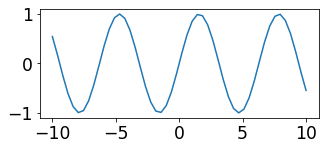

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-10'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

In [12]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [13]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)
GAINCORRECTIONFACTOR = 1.025

## Dispersion relation X - wavelength
$$
x = D \frac{N_{eff} \lambda p}{\sqrt{1-(N_{eff} \lambda p)^2}}
$$

In [17]:
def Dispersion(wl,neff,D,p=1):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl*p/np.sqrt(1-(wl*neff*p)**2)
    return X


## Dispersion rate dX/d lambda
$$
\frac{dx}{d\lambda} = D N_{eff} p \frac{\sqrt{1-(N_{eff}\lambda p)^2} + \frac{(N_{eff} \lambda p)^2}{\sqrt{1-(N_{eff} \lambda p)^2} }}{1-(N_{eff} \lambda p)^2} 
$$

$$
\frac{dx}{d\lambda} = \frac{D N_{eff} p}{\left(1-(N_{eff} \lambda p)^2\right)^{\frac{3}{2}}} 
$$

In [18]:
def Dispersion_Rate(wl,neff,D,p=1):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    #dxdlambda=D*neff*p*(np.sqrt(1-(wl*neff*p)**2)+ (wl*neff*p)**2/np.sqrt(1-(wl*neff*p)**2))/(1-(wl*neff*p)**2)
    dxdlambda=D*neff*p/(np.sqrt(1-(wl*neff*p)**2))**3
    return dxdlambda 

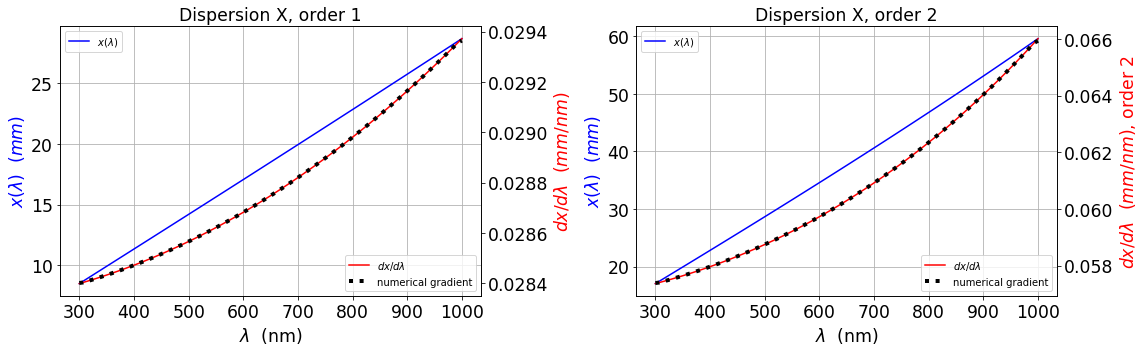

In [19]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

WL=np.linspace(300.,1000.,100)
neff=156. # lines per mm
D=184.45 # mm

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X, order 1")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


ax3 = fig.add_subplot(1,2,2)

Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")
ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax3.set_title("Dispersion X, order 2")
ax3.legend(loc="upper left")
ax3.grid()


ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)*1e-6 ## mm per nm
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($mm/ nm$), order 2",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")
#ax2.grid()


plt.tight_layout()


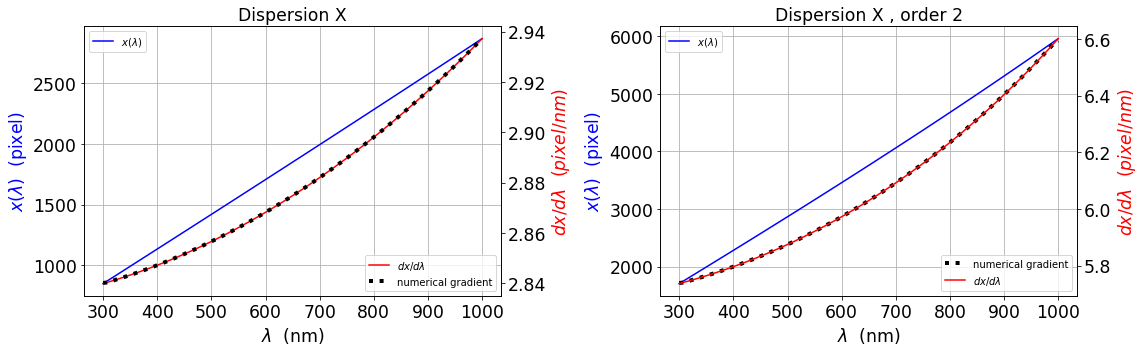

In [20]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()



ax3 = fig.add_subplot(1,2,2)


Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)/PIXELW   # pixel
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")

ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax3.set_title("Dispersion X , order 2")
ax3.legend(loc="upper left")
ax3.grid()

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)/PIXELW*1e-6   # pixel per nm
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")

plt.tight_layout()

## Multiplicative factor

$$
\frac{\left(\frac{dx}{d\lambda}\right)_{order =2}}{\left(\frac{dx}{d\lambda}\right)_{order =1}}
$$

Text(0.5, 1.0, 'Multiplicative factor order 2/order1 ')

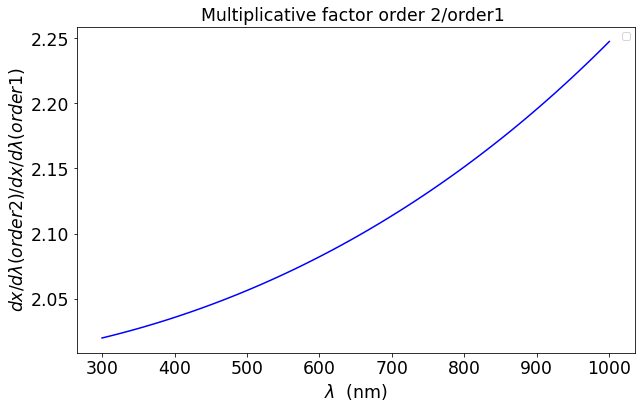

In [21]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,1,1)
latexlabel = "$\frac{\left(\frac{dx}{d\lambda}\right)_{order=2}}{\left(\frac{dx}{d\lambda}\right)_{order=1}}$"
ax1.plot(WL,Y4/Y2,"b-")
ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$dx/d\lambda(order2) / dx/d\lambda(order 1) $")
ax1.legend()
ax1.set_title("Multiplicative factor order 2/order1 ")

In [22]:
f_o2o1=interpolate.interp1d(WL,Y4/Y2,bounds_error=False,fill_value="extrapolate")

# Function

In [23]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [24]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [25]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [26]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

- spectrum need config

In [27]:
load_config("../runspectractor_standalone/2022_05/config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini")

No rebinning: parameters.REBIN is forced to 1.


In [28]:
# path index for each month
DATE="20211104"

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [29]:
top_path = "/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D"

In [30]:
#! ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104

In [31]:
#exposure ="2021110400508"  # ETADOR

#exposure = "2021110400263"  # HD205905
exposure = "2021110400274"   # HD009051 , creazy results

#exposure = "2021110400519"  # HD38949
#exposure = "2021110400542"   # HD031128
#exposure = "2021110400553"    #Mu Col
#exposure = "2021110400564"   # HD38949



In [32]:
path=os.path.join(os.path.join(top_path,DATE),exposure)

In [33]:
path_subdir=os.path.join(path,"basespec")

In [34]:
all_files = sorted(os.listdir(path_subdir))

In [35]:
all_files 

['exposure_2021110400274_postisrccd_lines.csv',
 'exposure_2021110400274_postisrccd_spectrogram.fits',
 'exposure_2021110400274_postisrccd_spectrum.fits',
 'exposure_2021110400274_postisrccd_table.csv']

# Read

## Read table

In [36]:
table = pd.read_csv(os.path.join(path_subdir,all_files[-1]))

In [37]:
table

,lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
0,321.115911,890.720698,1.768065,-4.352917,26.907345,-1.318412,10.871699,20.022569,11.779230,-8.243100,-1.318412,1.436606,196.034759,15.906769,2.077258,8500.118921
1,321.475327,891.720686,1.774225,-4.357804,11.711431,3.330572,10.839815,20.014395,11.781303,-8.232853,3.330572,2.436594,196.040919,15.900407,2.077298,8500.118921
2,321.834740,892.720674,1.780383,-4.362691,10.335605,0.129316,10.836725,20.006220,11.783374,-8.222608,0.129316,3.436582,196.047077,15.894052,2.077338,8500.118921
3,322.194150,893.720662,1.786539,-4.367578,18.575006,-0.557483,10.853663,19.998051,11.785446,-8.212367,-0.557483,4.436570,196.053233,15.887701,2.077378,8500.118921
4,322.553559,894.720650,1.792694,-4.372465,13.841216,1.100362,10.843302,19.989882,11.787516,-8.202127,1.100362,5.436558,196.059388,15.881356,2.077418,8500.118921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,1048.597801,2944.696171,10.913738,-14.390615,128.624206,103.528973,10.352272,17.271499,19.549384,2.278091,103.528973,2055.412079,205.180431,14.322056,2.235085,8500.118921
2055,1048.944429,2945.696159,10.916481,-14.395502,125.052485,105.017295,10.392363,17.275769,19.554263,2.278700,105.017295,2056.412067,205.183175,14.326880,2.235199,8500.118921
2056,1049.291049,2946.696147,10.919223,-14.400389,140.392566,105.455804,10.425119,17.281470,19.559855,2.278591,105.455804,2057.412055,205.185917,14.331709,2.235313,8500.118921
2057,1049.637658,2947.696135,10.921964,-14.405275,135.148309,108.571759,10.413140,17.289800,19.566760,2.277167,108.571759,2058.412043,205.188658,14.336544,2.235426,8500.118921


## Read Spectrum

In [38]:
spectrum = Spectrum(file_name=os.path.join(path_subdir,all_files[2]))

set date_obs to 2021-11-05T01:51:23.948
set expo to 20.0
set airmass to 1.06037825874769
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -24.3403888888889
set hour_angle to -20.93456535541785
set temperature to 5.9
set pressure to 741.1
set humidity to 47.0
set lambda_ref to 576.3774338842832
set parallactic_angle to -112.2644694071151


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = HD009051, Selected object name for Simbad : HD009051
 MAIN_ID        RA           DEC      ...  Z_VALUE   SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD   9051 01 28 46.5026 -24 20 25.442 ... -0.0002390                1


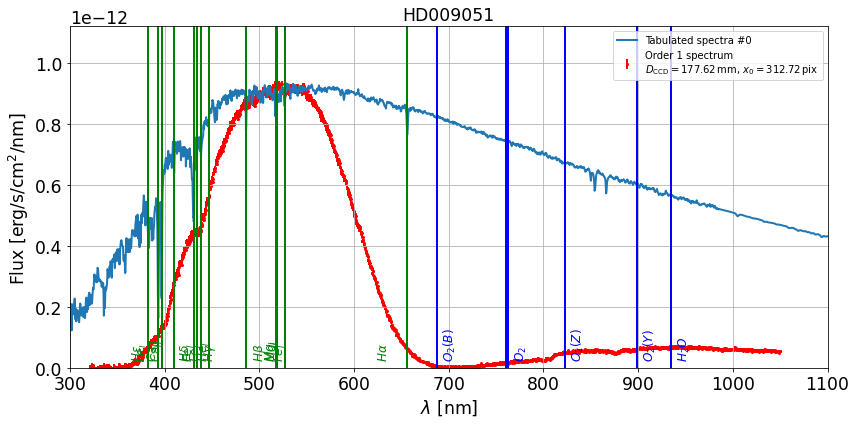

In [39]:
spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True)

In [40]:
spectrum.target.label

'HD009051'

- $S_\lambda(\lambda)$ : SED in erg/cm2/s/nm
- FLAM to ADU
$$
\frac{dN_{ADU}(\lambda)}{dN_{pix}} = \left( \frac{S \Delta T \epsilon_{eq}(\lambda)}{G_{el}} \right) \frac{1}{hc} \lambda \frac{d\lambda}{dN_{pix}} \cdot S_\lambda(\lambda)
$$

- ADU to FLAM

$$
S_\lambda(\lambda) = \frac{dn_\gamma(\lambda)}{d\lambda} = \frac{G_{el}}{S\Delta T \epsilon_{QE}(\lambda)} (hc) \frac{1}{\lambda} \left( \frac{dN_{pix}}{d\lambda}\right) \left(\frac{dN_{ADU}}{dN_{pix}} \right)
$$


- FLAM to ADU constant:
$$
FLAM\_TO\_ADURATE = \left( \frac{S}{G_{el}} \right) \frac{1}{hc} \times \left[ TIME \right ]_{unit}  \times \left[ \lambda d\lambda \right]_{unit}
\times \left[ SED \right ]_{unit} 
$$

# Disperser

In [41]:
spectrum.x0

[312.7158956908816, 1746.266693909048]

In [42]:
spectrum.order

1

In [43]:
spectrum.disperser.full_name

'Phase hologram #4-003'

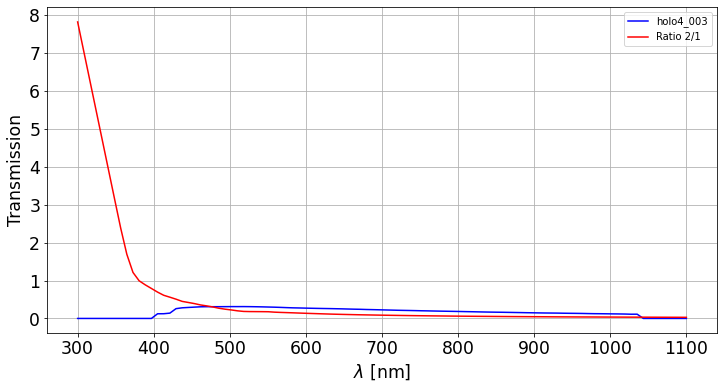

In [44]:
spectrum.disperser.plot_transmission()

In [45]:
spectrum.disperser.N([2000.,300.])

156

In [46]:
spectrum.disperser.load_specs()

In [47]:
my_distance=np.arange(0,6500)

In [48]:
spectrum.order

1

In [49]:
spectrum.x0

[312.7158956908816, 1746.266693909048]

## Check dispersion relation

In [50]:
neff0 = 156
DCCD0 = 181.45 

In [51]:
f = 1.0

In [52]:
neff = neff0*f
DCCD = DCCD0/f

In [53]:
my_lambdas = spectrum.disperser.grating_pixel_to_lambda(my_distance, [0,0], order=spectrum.order)
my_lambdas2 = spectrum.disperser.grating_pixel_to_lambda(my_distance, [0,0], order=2)

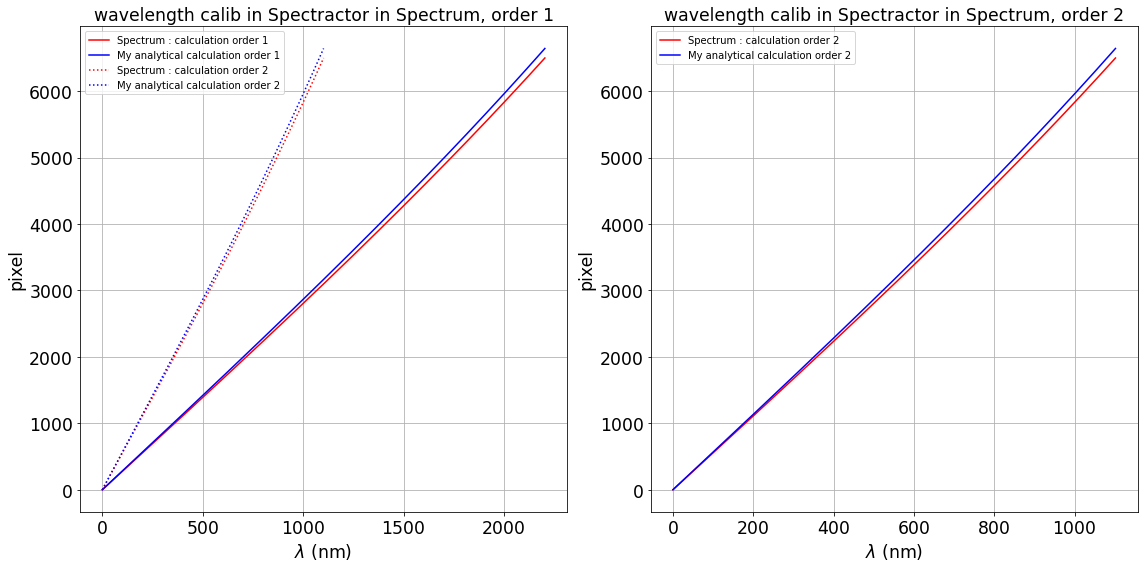

In [54]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
ax.plot(my_lambdas,my_distance,'r-',label="Spectrum : calculation order 1")

x_pix = Dispersion(my_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel 
x_pix2 = Dispersion(my_lambdas2*1e-6,neff,DCCD,p=2)/PIXELW   # pixel 


ax.plot(my_lambdas,x_pix,'b-',label="My analytical calculation order 1")
ax.plot(my_lambdas2,my_distance,'r:',label="Spectrum : calculation order 2")
ax.plot(my_lambdas2,x_pix2,'b:',label="My analytical calculation order 2")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("wavelength calib in Spectractor in Spectrum, order 1")

ax2=fig.add_subplot(122)
ax2.plot(my_lambdas2,my_distance,'r-',label="Spectrum : calculation order 2") 

ax2.plot(my_lambdas2,x_pix2,'b-',label="My analytical calculation order 2")
ax2.set_xlabel("$\\lambda$ (nm)")
ax2.set_ylabel("pixel")
ax2.grid()
ax2.legend()
ax2.set_title("wavelength calib in Spectractor in Spectrum, order 2")
plt.tight_layout()

## Check dispersion rate relation

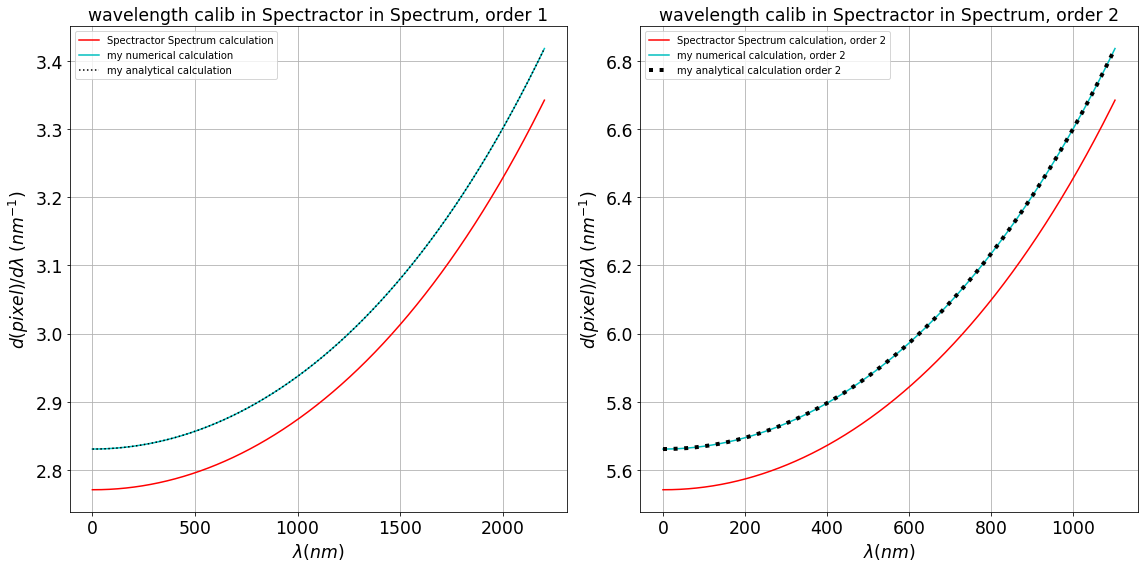

In [55]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
ax.plot(my_lambdas,np.gradient(my_distance,my_lambdas),'r-',label="Spectractor Spectrum calculation")
ax.plot(my_lambdas,np.gradient(x_pix,my_lambdas),'c-',label="my numerical calculation")
ax.plot(my_lambdas,Dispersion_Rate(my_lambdas*1e-6,neff,DCCD)/PIXELW*1e-6,"k:",label="my analytical calculation") 
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.grid()
ax.set_title("wavelength calib in Spectractor in Spectrum, order 1")
ax.legend()


ax1=fig.add_subplot(122)
ax1.plot(my_lambdas2,np.gradient(my_distance,my_lambdas2),'r-',label="Spectractor Spectrum calculation, order 2")
ax1.plot(my_lambdas2,np.gradient(x_pix2,my_lambdas2),'c-',label="my numerical calculation, order 2")
ax1.plot(my_lambdas2,Dispersion_Rate(my_lambdas2*1e-6,neff,DCCD,p=2)/PIXELW*1e-6,"k:",lw=4,label="my analytical calculation order 2") 
ax1.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax1.set_xlabel("$\lambda (nm)$")
ax1.grid()
ax1.set_title("wavelength calib in Spectractor in Spectrum, order 2")
ax1.legend()
plt.tight_layout()

## ratios dN/dlambdas

In [56]:
f_dndx_order1_mymodel =  interpolate.interp1d(my_lambdas,np.gradient(x_pix,my_lambdas),bounds_error=False,fill_value="extrapolate") 
f_dndx_order1_spectractor = interpolate.interp1d(my_lambdas,np.gradient(my_distance,my_lambdas),bounds_error=False,fill_value="extrapolate") 
f_dndx_order2_mymodel =  interpolate.interp1d(my_lambdas2,np.gradient(x_pix2,my_lambdas2),bounds_error=False,fill_value="extrapolate") 
f_dndx_order2_spectractor = interpolate.interp1d(my_lambdas2,np.gradient(my_distance,my_lambdas2),bounds_error=False,fill_value="extrapolate") 


In [57]:
WL3 = np.arange(1,1100)
f_dndx_order21ratio_mymodel = interpolate.interp1d(WL3,f_dndx_order2_mymodel(WL3)/f_dndx_order1_mymodel(WL3),bounds_error=False,fill_value="extrapolate") 
f_dndx_order21ratio_spectractor = interpolate.interp1d(WL3,f_dndx_order2_spectractor(WL3)/f_dndx_order1_spectractor(WL3),bounds_error=False,fill_value="extrapolate") 

Text(0.5, 1.0, '$d(pixel)/d\\lambda$ ratio (order-2/order-1)')

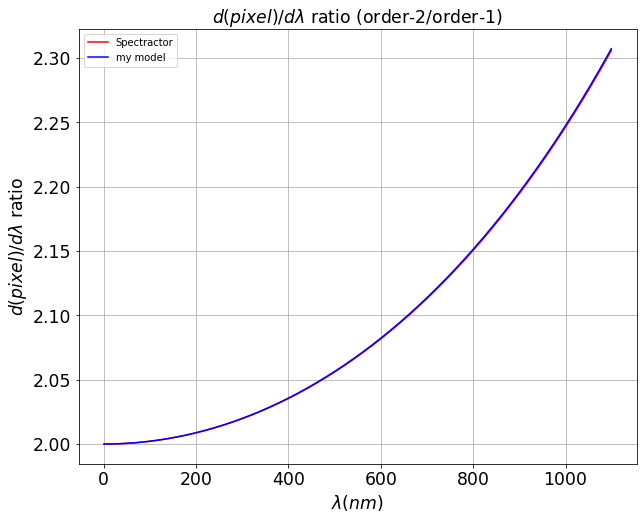

In [58]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)

ax.plot(WL3,f_dndx_order21ratio_spectractor(WL3),"r-",label="Spectractor")
ax.plot(WL3,f_dndx_order21ratio_mymodel(WL3),"b-",label="my model" )

ax.set_ylabel("$d(pixel)/d\lambda$ ratio")
ax.set_xlabel("$\lambda (nm)$")
ax.grid()
ax.legend()
ax.set_title("$d(pixel)/d\lambda$ ratio (order-2/order-1)")

# Work with table

In [59]:
WLCUT = 670

Text(0.5, 1.0, 'Table : wavelength calib in Spectractor')

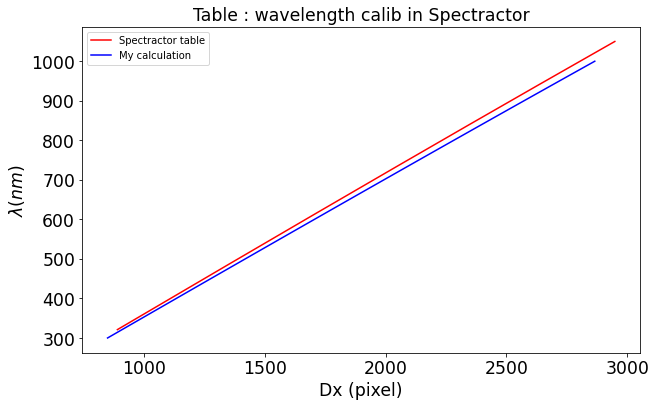

In [60]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.Dx,table.lambdas,"r-",label="Spectractor table")
ax.plot(Y1,WL,"b-",label="My calculation")
ax.set_xlabel("Dx (pixel)")
ax.set_ylabel("$\lambda (nm)$")
ax.legend()
ax.set_title("Table : wavelength calib in Spectractor")

Text(0.5, 1.0, 'wavelength calib in Spectractor table')

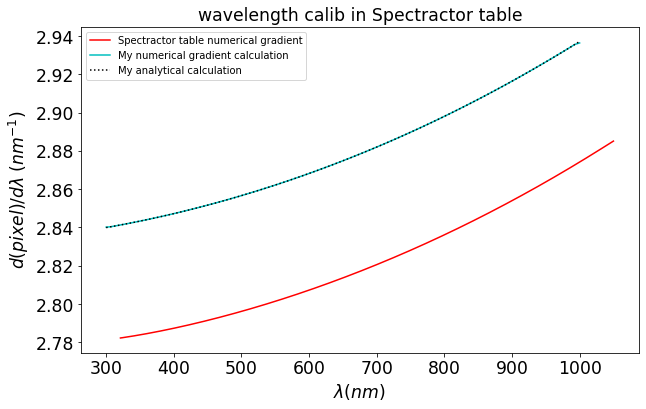

In [61]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.lambdas,np.gradient(table.Dx,table.lambdas),"r-",label="Spectractor table numerical gradient")
ax.plot(WL,np.gradient(Y1,WL),"c-",label="My numerical gradient calculation")
ax.plot(WL, Y2,"k:",label="My analytical calculation")
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.legend()
ax.set_title("wavelength calib in Spectractor table")

## Spectrum from Table

Text(0.5, 1.0, 'Spectrom from Spectractor Table')

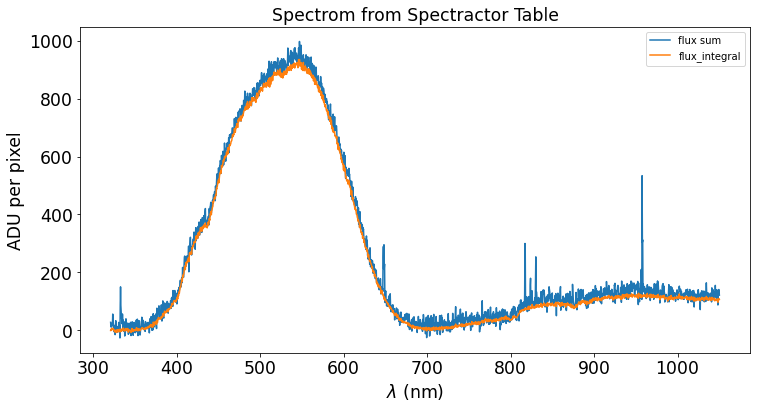

In [62]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(table.lambdas,table.flux_sum,label="flux sum")
ax.plot(table.lambdas,table.flux_integral,label="flux_integral")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("ADU per pixel")
ax.set_title("Spectrom from Spectractor Table")

## Extract order 2 and order 1 in Blue filter

In [63]:
order1_idx_t = np.where(table.lambdas.values<WLCUT)
order2_idx_t = np.where(table.lambdas.values>WLCUT)

In [64]:
wl1_t = table.lambdas.values[order1_idx_t] 
flux1_t= table.flux_sum.values[order1_idx_t] 

- order 2 is dispersed with $p=2$, then $\lambda \rightarrow \lambda_{position}/2$
- light for order 2 is dispersed on  twice pixel size

In [65]:
wl2_t = table.lambdas.values[order2_idx_t]/2.   # double dispersion
flux2_t= table.flux_sum.values[order2_idx_t]*f_dndx_order21ratio_spectractor(wl2_t) 

In [66]:
# I should compute f_o2o1(wl2_t) from Spectractor data (with Neff = 150)

Text(0.5, 1.0, 'Spectra order 1 and 2  from Spectractor Table')

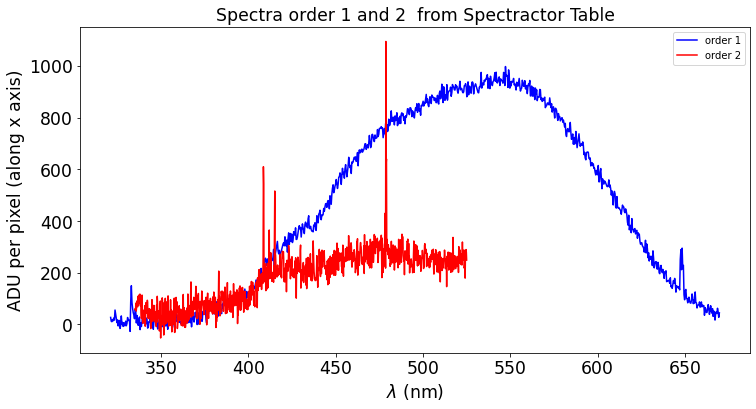

In [67]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_t,flux1_t,"b",label="order 1")
ax.plot(wl2_t,flux2_t,"r",label="order 2")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("ADU per pixel (along x axis)")
ax.set_title("Spectra order 1 and 2  from Spectractor Table")

## Compute ratio from Table

In [68]:
WL=np.arange(350.,520.)

In [69]:
f1_t=np.interp(WL,wl1_t,flux1_t)
f2_t=np.interp(WL,wl2_t,flux2_t)

In [70]:
ratio_t = f2_t/f1_t
ratio_filtered_t = savgol_filter(ratio_t, 25, 3) # window size 51, polynomial order 3

Text(0.5, 1.0, 'Spectrum ratio order 1 and 2 from Spectractor Table')

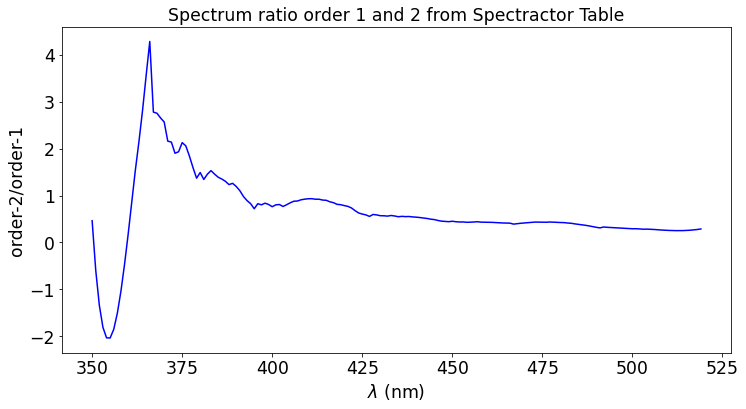

In [71]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(WL,ratio_filtered_t,'b')
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("order-2/order-1")
ax.set_title("Spectrum ratio order 1 and 2 from Spectractor Table")

## Compute ratio with Spectrum

In [72]:
order1_idx_s = np.where(spectrum.lambdas<WLCUT)
order2_idx_s = np.where(spectrum.lambdas>WLCUT)

In [73]:
wl1_s = spectrum.lambdas[order1_idx_s] 
flux1_s= spectrum.data[order1_idx_s] 
flux1err_s= spectrum.err[order1_idx_s] 

- order 2 is dispersed with $p=2$, then $\lambda \rightarrow \lambda_{position}/2$
- light for order 2 is dispersed on  twice pixel size, and when one convert ADU rate into FLAM we divide the ADU rate by the factor $(p\lambda) d(p \lambda)$

In [74]:
wl2_s = spectrum.lambdas[order2_idx_s]/2. 
flux2_s= spectrum.data[order2_idx_s]*(f_dndx_order21ratio_spectractor(wl2_s))**2
flux2err_s = spectrum.err[order2_idx_s]*(f_dndx_order21ratio_spectractor(wl2_s))**2

In [75]:
spectrum.err[order2_idx_s]

array([2.58966842e-15, 2.59980169e-15, 2.58432092e-15, ...,
       2.08428372e-15, 2.09753196e-15, 2.08642026e-15])

Text(0.5, 1.0, 'Fluxes : order 1 & 2')

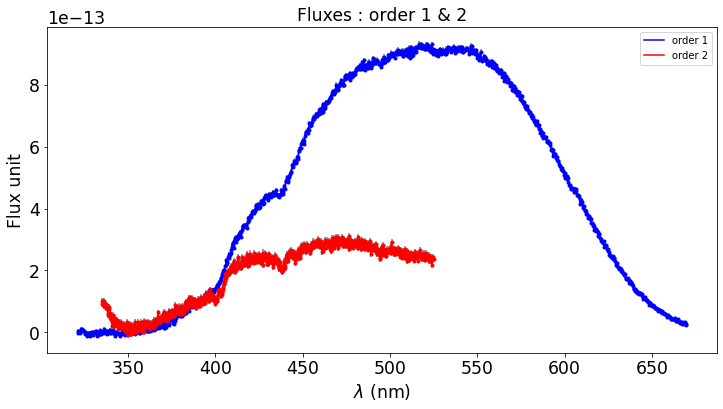

In [76]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_s,flux1_s,"b",label="order 1")
ax.errorbar(wl1_s,flux1_s,yerr=flux1err_s,color="b",ecolor="grey",marker=".")

ax.plot(wl2_s,flux2_s,"r",label="order 2")
ax.errorbar(wl2_s,flux2_s,yerr=flux2err_s,color="r",ecolor="grey",marker=".")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux unit")
ax.set_title("Fluxes : order 1 & 2")

Text(0.5, 1.0, 'Flux error : order 1 & 2')

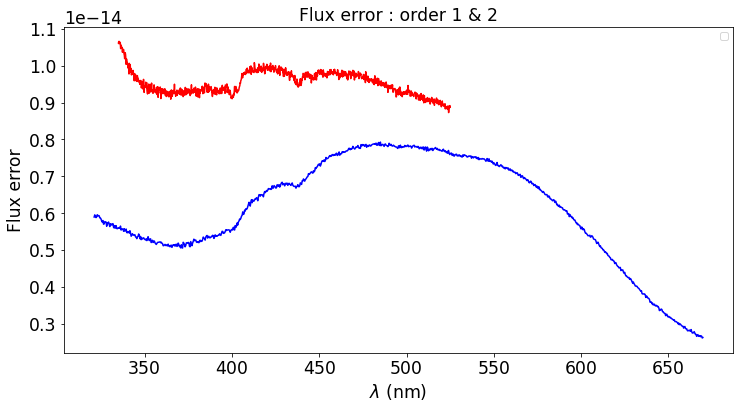

In [77]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_s,flux1err_s,'b-')
ax.plot(wl2_s,flux2err_s,'r-')
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux error")
ax.set_title("Flux error : order 1 & 2")

In [78]:
f1_s=np.interp(WL,wl1_s,flux1_s)
f2_s=np.interp(WL,wl2_s,flux2_s)
f1err_s=np.interp(WL,wl1_s,flux1err_s)
f2err_s=np.interp(WL,wl2_s,flux2err_s)

In [79]:
ratio_s = f2_s/f1_s/GAINCORRECTIONFACTOR
ratioerr_s = (f1_s*f2err_s+ f2_s*f1err_s)/f1_s**2
ratio_filtered_s = savgol_filter(ratio_s, 25, 3) # window size 51, polynomial order 3

(0.0, 5.0)

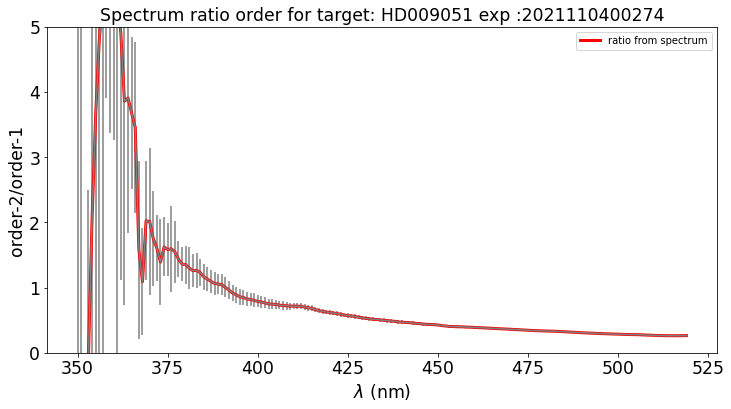

In [80]:
fig=plt.figure()
ax=fig.add_subplot(111)
#ax.plot(WL,ratio_filtered_t ,'b',label="ratio from table",alpha=0.1)
ax.errorbar(WL,ratio_filtered_s,yerr=ratioerr_s ,color='grey')
ax.plot(WL,ratio_filtered_s ,color='r',label="ratio from spectrum",lw=3)
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("order-2/order-1")
ax.legend()
ax.set_title(f"Spectrum ratio order for target: {spectrum.target.label} exp :{exposure}")
ax.set_ylim(0,5.)

# Save order2/order1 in file

In [81]:
exposure

'2021110400274'

In [82]:
filename_out = "order2order1_" + exposure + ".csv" 

In [83]:
filename_out

'order2order1_2021110400274.csv'

In [84]:
df_out = pd.DataFrame()

In [85]:
df_out["lambdas"]   = WL
df_out["ratioo2o1"] = ratio_filtered_s
df_out["ratioo2o1err"] = ratioerr_s 

In [86]:
df_out.to_csv(filename_out)